# ECE 461/561 - Mini Project \#1
## Two-Transmission-Link Queueing System Simulator and Output
***
## Code

In [1]:
%matplotlib inline
from pylab import *
import numpy as np
from collections import deque

In [2]:
class Queue:
    """A queue for use in simulating M/M/1/k.
    
    Attributes:
        k (int): Maximum customers allowed in the system.
        departures (list): A sample of departure intervals.
        queue (list): A deque object.
        dropped (int): Number of items dropped because queue was full.
        served (int): Number of items served from queue.
    """
    
    def __init__(self, k, mu, departures):
        """Forms a queue.

        Args:
            k (int): Maximum customers allowed in the system.
            mu (float): Rate out of the queue.
            departures (int): Number of departure intervals to generate.
        """
        self.k = k
        # Generates the departure intervals
        # according to an exponential distribution.
        self.departures = exponential(1/mu, departures)
        self.queue = deque([], k)
        self.dropped = 0
        self.served = 0
        
    def empty(self):
        """Checks if the queue is empty.
        
        Returns:
            True if empty, False otherwise.
        """
        return len(self.queue) is 0
    
    def is_full(self):
        """Checks if the queue is full.
        
        Returns:
            True if full, False otherwise.
        """
        return len(self.queue) is self.k
    
    def enqueue(self, item):
        """Adds an item to end of the queue.
        
        Args:
            item: An item to add to the queue.
        """
        if self.is_full():
            self.dropped += 1
        else:
            self.queue.append(item)
        
    def dequeue(self):
        """Removes the fist item from the queue."""
        if not self.empty():
            self.served += 1
            return self.queue.popleft()
        return None
            
    def get_size(self):
        """Get the size of the queue.
        
        Returns:
            An integer for the size of the queue.
        """
        return len(self.queue)

In [3]:
def simulation(lamb, mu, k, phi, samples):
    """Used to run a simulation of an M/M/1/k network.
    
    Args:
        lamb (float): The rate into the entire network.
        mu (float): The rate out of the two queues in the network.
        k (int): Maximum number of customers the two queues can handle.
        phi (float): Probability an arrival goes to the first queue.
        samples (int): Number of packets to sample. Defaults to 6000.
    """
    queue1 = Queue(k, mu, samples*2)
    queue2 = Queue(k, mu, samples*2)
    # Counts arrivals to each node.
    queue1_arrivals, queue2_arrivals = 0, 0
    # Count time passed.
    time = 0
    # Indexes for sample space lists.
    i, j, n, m = 0, 0, 0, 0
    # Lists for obtaining average number of packets and time in queue.
    queue1_size, queue2_size = [], []
    queue1_time, queue2_time = [0], [0]
    # Iterate over entire sample of arrivals.
    while queue1.served < samples and queue2.served < samples:
        # Generate an interarrival time.
        arrivals = exponential(1/lamb)
        # Idle state, ignores output rates.
        if time is 0:
            if random() < phi:
                queue1_arrivals += 1
                queue1.enqueue(0)
            else:
                queue2_arrivals += 1
                queue2.enqueue(0)
            # Increments time by one arrival interval.
            time += arrivals
        else:
            # Dequeues any packets that should have been processed
            # before the next arrival.
            while queue1.departures[i] <= time:
                t = queue1.dequeue() 
                if t is not None:
                    queue1_time.append(queue1.departures[i] - t)
                # Sums the intervals to compare with time since arrival.
                queue1.departures[i+1] += queue1.departures[i]
                i += 1
                if queue1.served > 1000:
                    queue1_size.append(queue1.get_size())
            while queue2.departures[j] <= time:
                t = queue2.dequeue() 
                if t is not None:
                    queue2_time.append(queue2.departures[j] - t)
                queue2.departures[j+1] += queue2.departures[j]
                j += 1
                if queue2.served > 1000:
                    queue2_size.append(queue2.get_size())
            # Splits arrivals based on phi probability.
            if random() < phi:
                queue1_arrivals += 1
                queue1.enqueue(time)
            else:
                queue2_arrivals += 1
                queue2.enqueue(time)
            if queue1.served > 1000 or queue2.served > 1000:
                queue1_size.append(queue1.get_size())
                queue2_size.append(queue2.get_size())
            # Increments time by one arrival interval.
            time += arrivals
    
    # Print the metrics for the queues.
    print_metrics(lamb, mu, k, phi, samples, time,
                  queue1, queue1_arrivals, queue1_size, queue1_time,
                  queue2, queue2_arrivals, queue2_size, queue2_time)

def print_metrics(lamb, mu, k, phi, samples, time,
                  queue1, queue1_arrivals, queue1_size, queue1_time,
                  queue2, queue2_arrivals, queue2_size, queue2_time):
    """Prints the metrics for the system, queue1, and queue2.
    
    Args:
        lamb (float): The rate into the entire network.
        mu (float): The rate out of the two queues in the network.
        k (int): Maximum number of customers the two queues can handle.
        phi (float): Probability an arrival goes to the first queue.
        samples (int): Number of packets sampled.
        time: The runtime of the system.
        queue1 (Queue): The first Queue object.
        queue1_arrivals: The number of arrivals into the system.
        queue1_size (list): A list of the number of items in queue at different times.
        queue1_time (list): A list of the delay for each packet that left the system.
        queue2 (Queue): The second Queue object.
        queue2_arrivals: The number of arrivals into the system.
        queue2_size (list): A list of the number of items in queue at different times.
        queue2_time (list): A list of the delay for each packet that left the system.
    """
    # Calculate and print results.
    # Queue 1.
    # Blocking probability. 
    e_pb1 = eval_blocking(lamb*phi, mu, k)
    pb1 = queue1.dropped/queue1_arrivals
    # Average delay.
    e_et1 = eval_delay(lamb*phi, mu, k, e_pb1)
    et1 = average(queue1_time)
    # Average number of packets in system.
    rho = phi*lamb/mu
    e_n1 = (rho/(1-rho))-((k+1)*rho**(k+1)/(1-rho**(k+1)))
    n1 = average(queue1_size)
    # Throughput.
    e_thru1 = e_n1/e_et1
    thru1 = n1/et1
    # Queue 2.
    # Blocking probability.
    e_pb2 = eval_blocking(lamb*(1-phi), mu, k)
    pb2 = queue2.dropped/queue2_arrivals
    # Average delay.
    e_et2 = eval_delay(lamb*(1-phi), mu, k, e_pb2)
    et2 = average(queue2_time)
    # Average number of packets in system.
    rho = (1-phi)*lamb/mu
    e_n2 = (rho/(1-rho))-((k+1)*rho**(k+1)/(1-rho**(k+1)))
    n2 = average(queue2_size)
    # Throughput.
    e_thru2 = e_n2/e_et2
    thru2 = n2/et2
    # Whole system.
    # Blocking probability.
    e_pb = phi*e_pb1 + (1-phi)*e_pb2
    pb = (queue1.dropped+queue2.dropped)/(queue1_arrivals + queue2_arrivals)
    # Average delay.
    e_et = phi*e_et1 + (1-phi)*e_et2
    et = average(queue1_time+queue2_time)
    # Average number of packets in system.
    e_n = phi*e_n1 + (1-phi)*e_n2
    n = average(queue1_size+queue2_size)
    # Throughput.
    e_thru = average([e_thru1, e_thru2])
    thru = n/et
    
    print("\nSimulation of two M/M/1/{0} queues with phi={1}:\n".format(k,phi))
    # Whole system.
    system_metrics = {'expected_blocking':e_pb, 'blocking':pb, 'expected_delay':e_et, 'delay':et,
              'expected_number':e_n, 'number':n, 'expected_throughput':e_thru, 'throughput':thru}
    print("\tSystem:")
    print("\t\tBlocking probability:\n\t\t\tExpected: ", e_pb)
    print("\t\t\tSimulated: ", pb)
    print("\t\tAverage delay in seconds:\n\t\t\tExpected: ", e_et)
    print("\t\t\tSimulated: ", et)
    print("\t\tAverage number of packets:\n\t\t\tExpected: ", e_n)
    print("\t\t\tSimulated: ", n)
    print("\t\tThroughput in packets/second:\n\t\t\tExpected: ", e_thru)
    print("\t\t\tSimulated: ", thru)
    # Queue 1.
    queue1_metrics = {'expected_blocking':e_pb, 'blocking':pb, 'expected_delay':e_et, 'delay':et,
              'expected_number':e_n, 'number':n, 'expected_throughput':e_thru, 'throughput':thru}
    print("\n\tQueue 1:")
    print("\t\tBlocking probability:\n\t\t\tExpected: ", e_pb1)
    print("\t\t\tSimulated: ", pb1)
    print("\t\tAverage delay in seconds:\n\t\t\tExpected: ", e_et1)
    print("\t\t\tSimulated: ", et1)
    print("\t\tAverage number of packets:\n\t\t\tExpected: ", e_n1)
    print("\t\t\tSimulated: ", n1)
    print("\t\tThroughput in packets/second:\n\t\t\tExpected: ", e_thru1)
    print("\t\t\tSimulated: ", thru1)
    # Queue 2.
    queue2_metrics = {'expected_blocking':e_pb, 'blocking':pb, 'expected_delay':e_et, 'delay':et,
              'expected_number':e_n, 'number':n, 'expected_throughput':e_thru, 'throughput':thru}
    print("\n\tQueue 2:")
    print("\t\tBlocking probability:\n\t\t\tExpected: ", e_pb2)
    print("\t\t\tSimulated: ", pb2)
    print("\t\tAverage delay in seconds:\n\t\t\tExpected: ", e_et2)
    print("\t\t\tSimulated: ", et2)
    print("\t\tAverage number of packets:\n\t\t\tExpected: ", e_n2)
    print("\t\t\tSimulated: ", n2)
    print("\t\tThroughput in packets/second:\n\t\t\tExpected: ", e_thru2)
    print("\t\t\tSimulated: ", thru2)
    
    f, (ax1, ax2) = subplots(1, 2, sharey=True)
    f.suptitle("Distribution of Packets in Queue as a Factor of Runtime")
    ax1.hist(queue1_size)
    ax1.set_title("Queue 1")
    #ax1.fill_between(range(0,len(queue1_size)), queue1_size)
    ax1.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off') # labels along the bottom edge are off'''
    ax1.set_ylabel("Runtime")
    ax1.set_xlabel("Packets in Queue")
    ax2.hist(queue2_size)
    ax2.set_title("Queue 2")
    #ax2.fill_between(range(0,len(queue2_size)), queue2_size)
    ax2.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off') # labels along the bottom edge are off
    ax2.set_ylabel("Runtime")
    ax2.set_xlabel("Packets in Queue")
    show()

def eval_blocking(lamb, mu, k):
    """Finds the blocking probability of a queue.
    
    Args:
        lamb (float): The rate into the queue.
        mu (float): The rate out of the queue.
        k (int): Maximum number of customers able to be in the queue.
    """
    rho = lamb/mu
    return rho**k*((1-rho)/(1-rho**(k+1)))

def eval_delay(lamb, mu, k, pb):
    """Finds the average delay of a queue.
    
    Args:
        lamb (float): The rate into the queue.
        mu (float): The rate out of the queue.
        k (int): Maximum number of customers able to be in the queue.
        pb (float): The blocking probability for the queue.
    """
    rho = lamb/mu
    en = (rho/(1-rho))-((k+1)*rho**(k+1)/(1-rho**(k+1)))
    return en/(lamb*(1-pb))

***
## Results
### Configuration 1:
* $\mu1 = 5\,packets/sec$
* $\mu2 = 5\,packets/sec$
* $\lambda = 8\,packets/sec$
* $buffer = 20$
* $\phi = 0.4, 0.5, 0.6$


Simulation of two M/M/1/21 queues with phi=0.4:

	System:
		Blocking probability:
			Expected:  0.017195624672635433
			Simulated:  0.020029168692270297
		Average delay in seconds:
			Expected:  1.364629618009292
			Simulated:  1.45998980657
		Average number of packets:
			Expected:  6.037810579705681
			Simulated:  5.85768933682
		Throughput in packets/second:
			Expected:  3.93121750131
			Simulated:  4.01214399612

	Queue 1:
		Blocking probability:
			Expected:  3.062708051975666e-05
			Simulated:  0.0
		Average delay in seconds:
			Expected:  0.5551982286722792
			Simulated:  0.501615432239
		Average number of packets:
			Expected:  1.7765799186285607
			Simulated:  1.65331440102
		Throughput in packets/second:
			Expected:  3.199901993342337
			Simulated:  3.29597993753

	Queue 2:
		Blocking probability:
			Expected:  0.028638956400712554
			Simulated:  0.03313495254946115
		Average delay in seconds:
			Expected:  1.9042505442339672
			Simulated:  2.10918024677
		Average number o

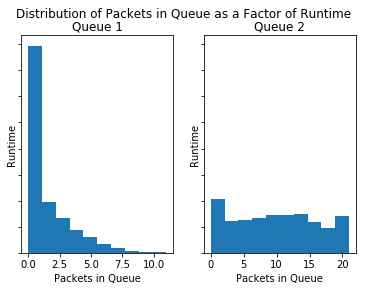


Simulation of two M/M/1/21 queues with phi=0.5:

	System:
		Blocking probability:
			Expected:  0.0018583868822537061
			Simulated:  0.0012650754828371427
		Average delay in seconds:
			Expected:  0.9609012148031506
			Simulated:  0.994559118709
		Average number of packets:
			Expected:  3.836461954361675
			Simulated:  4.05892834813
		Throughput in packets/second:
			Expected:  3.99256645247
			Simulated:  4.08113331

	Queue 1:
		Blocking probability:
			Expected:  0.0018583868822537061
			Simulated:  0.00016655562958027982
		Average delay in seconds:
			Expected:  0.9609012148031506
			Simulated:  0.849751181109
		Average number of packets:
			Expected:  3.836461954361675
			Simulated:  3.62284859067
		Throughput in packets/second:
			Expected:  3.992566452470985
			Simulated:  4.26342283625

	Queue 2:
		Blocking probability:
			Expected:  0.0018583868822537061
			Simulated:  0.0023919357594396036
		Average delay in seconds:
			Expected:  0.9609012148031506
			Simulated:  1.14341016

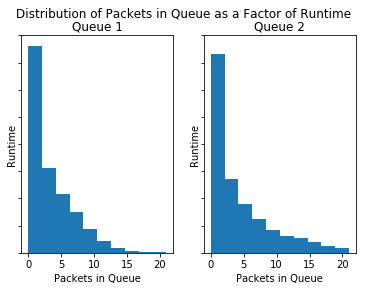


Simulation of two M/M/1/21 queues with phi=0.6:

	System:
		Blocking probability:
			Expected:  0.017195624672635433
			Simulated:  0.015041289815178922
		Average delay in seconds:
			Expected:  1.364629618009292
			Simulated:  1.30802423098
		Average number of packets:
			Expected:  6.037810579705681
			Simulated:  5.39846403781
		Throughput in packets/second:
			Expected:  3.93121750131
			Simulated:  4.12718962686

	Queue 1:
		Blocking probability:
			Expected:  0.028638956400712554
			Simulated:  0.02478134110787172
		Average delay in seconds:
			Expected:  1.9042505442339672
			Simulated:  1.83092439405
		Average number of packets:
			Expected:  8.878631020423763
			Simulated:  8.87163426926
		Throughput in packets/second:
			Expected:  4.662533009276579
			Simulated:  4.84543998546

	Queue 2:
		Blocking probability:
			Expected:  3.062708051975666e-05
			Simulated:  0.0
		Average delay in seconds:
			Expected:  0.5551982286722792
			Simulated:  0.522758453342
		Average number of

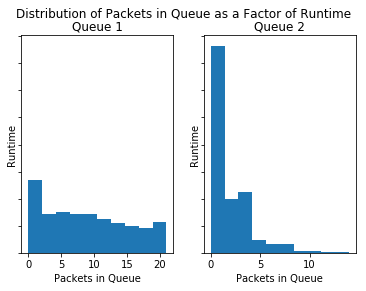

In [4]:
simulation(8, 5, 21, 0.4, 6000)
simulation(8, 5, 21, 0.5, 6000)
simulation(8, 5, 21, 0.6, 6000)

### Configuration 2:
* $\mu1 = 5\,packets/sec$
* $\mu2 = 5\,packets/sec$
* $\lambda = 8\,packets/sec$
* $buffer = 5$
* $\phi = 0.4, 0.5, 0.6$


Simulation of two M/M/1/6 queues with phi=0.4:

	System:
		Blocking probability:
			Expected:  0.08593320245468473
			Simulated:  0.07779564130046446
		Average delay in seconds:
			Expected:  0.5925298378368264
			Simulated:  0.570751222008
		Average number of packets:
			Expected:  2.2844636689798294
			Simulated:  2.11256837804
		Throughput in packets/second:
			Expected:  3.65626719018
			Simulated:  3.7013821374

	Queue 1:
		Blocking probability:
			Expected:  0.025877098450538878
			Simulated:  0.019296254256526674
		Average delay in seconds:
			Expected:  0.46700718583965284
			Simulated:  0.437186603875
		Average number of packets:
			Expected:  1.4557516637266275
			Simulated:  1.3661066863
		Throughput in packets/second:
			Expected:  3.117193284958276
			Simulated:  3.1247679462

	Queue 2:
		Blocking probability:
			Expected:  0.12597060512411531
			Simulated:  0.11574142247091739
		Average delay in seconds:
			Expected:  0.6762116058349422
			Simulated:  0.66690172198
		Ave

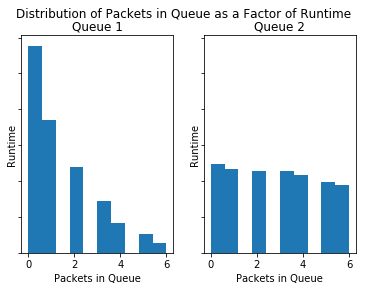


Simulation of two M/M/1/6 queues with phi=0.5:

	System:
		Blocking probability:
			Expected:  0.06634165303445037
			Simulated:  0.06473528033734187
		Average delay in seconds:
			Expected:  0.5736664064532917
			Simulated:  0.569222109882
		Average number of packets:
			Expected:  2.1424337150353896
			Simulated:  2.13064558021
		Throughput in packets/second:
			Expected:  3.73463338786
			Simulated:  3.74308296046

	Queue 1:
		Blocking probability:
			Expected:  0.06634165303445037
			Simulated:  0.06521739130434782
		Average delay in seconds:
			Expected:  0.5736664064532917
			Simulated:  0.576761290252
		Average number of packets:
			Expected:  2.1424337150353896
			Simulated:  2.1618898732
		Throughput in packets/second:
			Expected:  3.734633387862198
			Simulated:  3.74832692439

	Queue 2:
		Blocking probability:
			Expected:  0.06634165303445037
			Simulated:  0.06425452276980662
		Average delay in seconds:
			Expected:  0.5736664064532917
			Simulated:  0.561719362811
		Ave

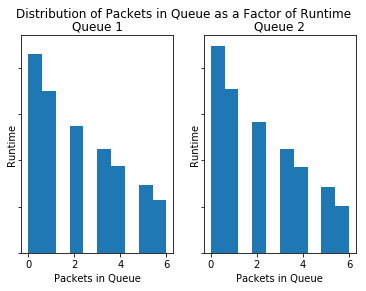


Simulation of two M/M/1/6 queues with phi=0.6:

	System:
		Blocking probability:
			Expected:  0.08593320245468473
			Simulated:  0.08432366305487592
		Average delay in seconds:
			Expected:  0.5925298378368264
			Simulated:  0.580957535758
		Average number of packets:
			Expected:  2.2844636689798294
			Simulated:  2.14123498806
		Throughput in packets/second:
			Expected:  3.65626719018
			Simulated:  3.68569965318

	Queue 1:
		Blocking probability:
			Expected:  0.12597060512411531
			Simulated:  0.12492711370262391
		Average delay in seconds:
			Expected:  0.6762116058349422
			Simulated:  0.669751437781
		Average number of packets:
			Expected:  2.836938339148631
			Simulated:  2.79766059196
		Throughput in packets/second:
			Expected:  4.195341095404246
			Simulated:  4.1771625026

	Queue 2:
		Blocking probability:
			Expected:  0.025877098450538878
			Simulated:  0.02356020942408377
		Average delay in seconds:
			Expected:  0.46700718583965284
			Simulated:  0.461911019664
		Av

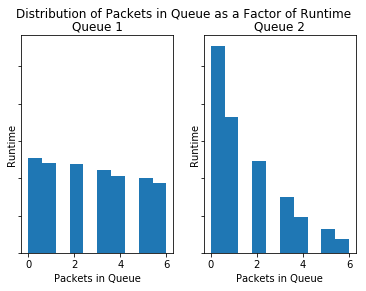

In [5]:
simulation(8, 5, 6, 0.4, 6000)
simulation(8, 5, 6, 0.5, 6000)
simulation(8, 5, 6, 0.6, 6000)

***
## Conclusions
The value of $\phi$ has an interesting impact on the system's behavior. As can be seen from the graphs, if $\phi$ is not equal then there is a queue being underutilized with too much runtime spent with too few packets in queue. This affects throughput negatively as can be seen from the expected and simulated results. Buffer size also plays an important role as it changes the probability that a packet will be blocked from entering the queue. An decrease in the buffer size will also negatively impact the throughput as the queue will not be able to utilize the full capability of the service rate.

From, the results of the simulations the system with a buffer size of 20 and a $\phi$ of 0.5 is the best configuration in terms of throughput. This is obvious from the observed results. A larger buffer will allow better utilization of the service time with fewer blockings happening, and a $\phi$ of 0.5 will make sure a queue is not being underutilized.